In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



import warnings
warnings.filterwarnings("ignore")

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive/')

import sys

#-------------------------------------------------------------------#
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, titleweight='bold')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#-------------------------------------------------------------------#

Mounted at /content/gdrive/


In [ ]:
def pca_factor_loadings(Z,load,labels=None):
    xs = Z[:,0]
    ys = Z[:,1]
    n = load.shape[0]

    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,edgecolors='k')
    
    for i in range(n):
        plt.arrow(0, 0, load[i,0],load[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(load[i,0]* 1.15, load[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(load[i,0]* 1.15, load[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
#-------------------------------------------------------------------------------
def my_scorer(estimator, X, y=None):
    X_reduced = estimator.transform(X)
    X_preimage = estimator.inverse_transform(X_reduced)
    return -1 * mean_squared_error(X, X_preimage)   

# **Import Dataset**

In [ ]:
# read  csv file
import io
uploaded = files.upload()
df=pd.read_csv(io.BytesIO(uploaded['Geologic_DataSet.csv']),sep=";",decimal=',')

# replace some headers
df.rename(columns={'GR_API': 'API',
                   'Bulk Density, gcc': 'Bulk Density',
                   'Resistivity, ohm-m':'Resistivity',
                   'Water Saturation, fraction':'Water Saturation',
                   'PhiH, ft': 'PhiH',
                   'TOC, fraction':'TOC',
                   'TVD, ft':'TVD'},
           inplace=True)

Saving Geologic_DataSet.csv to Geologic_DataSet (1).csv


In [ ]:
df.head()

,API,Bulk Density,Resistivity,Water Saturation,PhiH,TOC,TVD,Unnamed: 7
0,118.0,2.2096,23.0,0.13,23.0,0.077,10670.0,NaN
1,170.0,2.2185,21.0,0.17,20.0,0.073,9932.0,NaN
2,166.0,2.2260,14.0,0.20,21.0,0.070,9747.0,NaN
3,166.0,2.2260,14.0,0.20,21.0,0.070,9747.0,NaN
4,135.0,2.2303,22.0,0.16,24.0,0.068,9222.0,NaN


# **Data Cleansing**

In [ ]:
#check % of missing values
df.isnull().mean()*100

API                   9.876543
Bulk Density          9.876543
Resistivity           9.876543
Water Saturation      9.876543
PhiH                  9.876543
TOC                   9.876543
TVD                   9.876543
Unnamed: 7          100.000000
dtype: float64

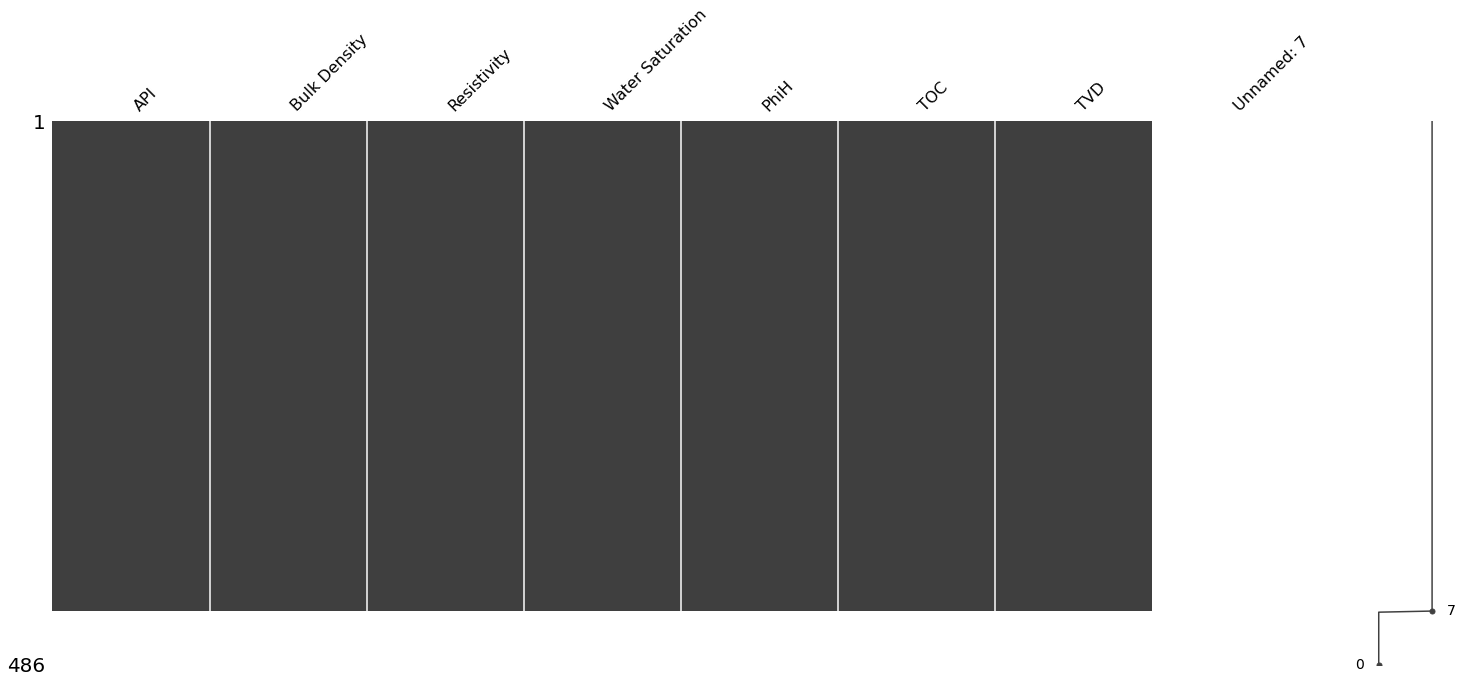

In [ ]:
#see matrix os missing values
import missingno as msno
ax=msno.matrix(df)
ax.get_figure().savefig("missing.png")

In [ ]:
# find columns where all
# rows are NULL and get
# rid of them
cols_all_null=df.columns[df.isna().all()].tolist()
df.drop(cols_all_null,axis=1,inplace=True)

# find rows where all
# columns are NULL and get
# rid of them
rows_all_null=df.index[df.isna().all(axis=1)].tolist()
df.drop(rows_all_null,axis=0,inplace=True)

In [ ]:
#check % of missing values
df.isnull().mean()*100

API                 0.0
Bulk Density        0.0
Resistivity         0.0
Water Saturation    0.0
PhiH                0.0
TOC                 0.0
TVD                 0.0
dtype: float64

In [ ]:
# see if all columns are float
df.dtypes

API                 float64
Bulk Density        float64
Resistivity         float64
Water Saturation    float64
PhiH                float64
TOC                 float64
TVD                 float64
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438 entries, 0 to 437
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   API               438 non-null    float64
 1   Bulk Density      438 non-null    float64
 2   Resistivity       438 non-null    float64
 3   Water Saturation  438 non-null    float64
 4   PhiH              438 non-null    float64
 5   TOC               438 non-null    float64
 6   TVD               438 non-null    float64
dtypes: float64(7)
memory usage: 27.4 KB


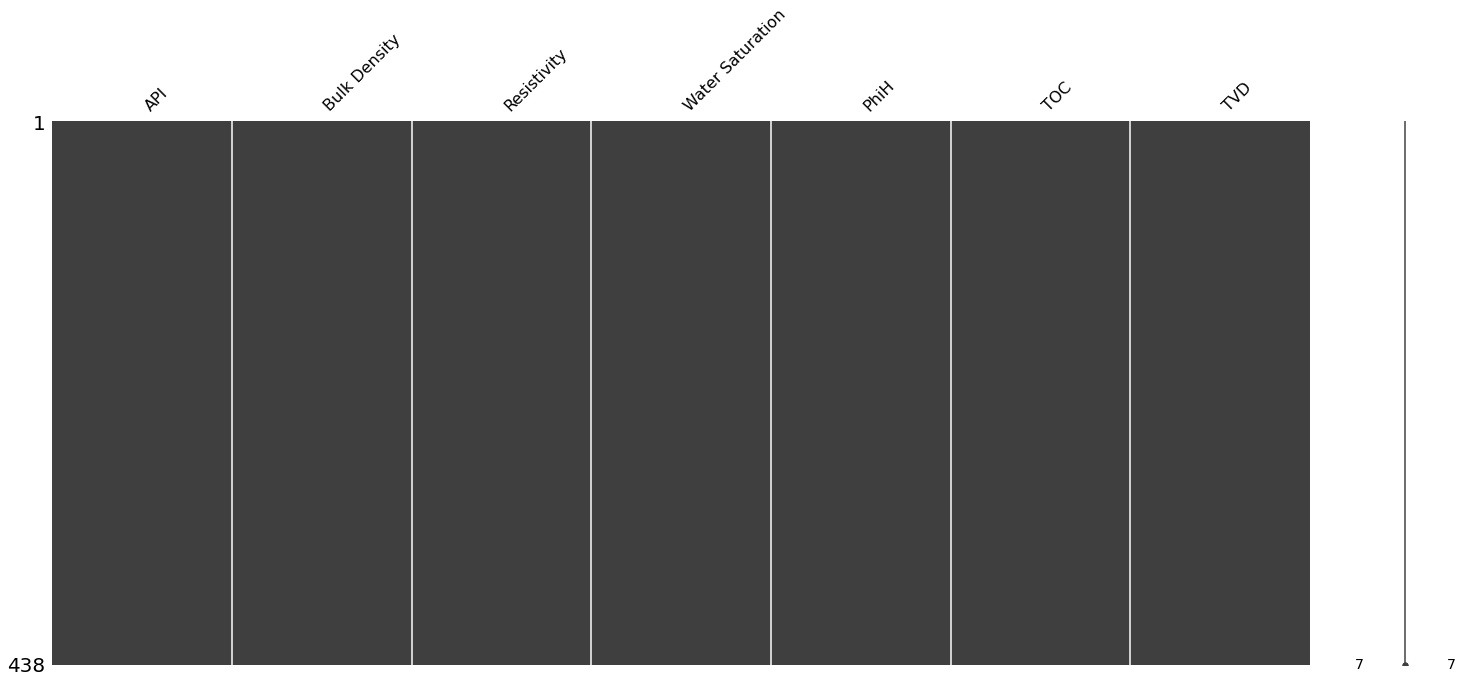

In [ ]:
import missingno as msno
ax=msno.matrix(df)
ax.get_figure().savefig("missing.png")

# **Cross-plots**

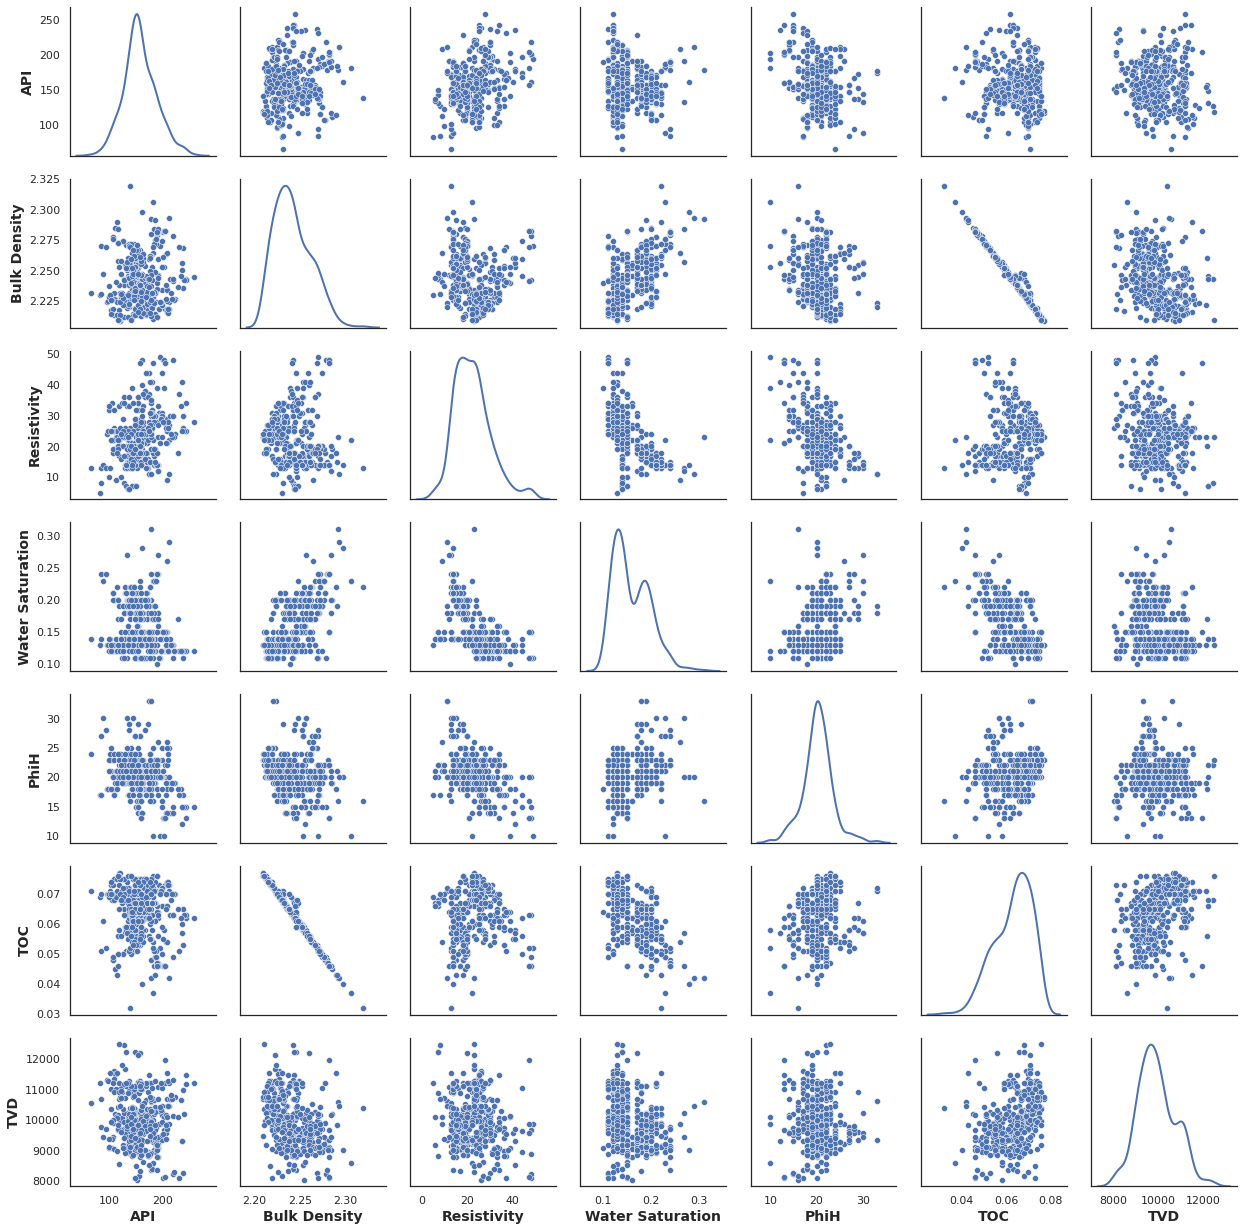

In [ ]:
sns.set(style="white")
sns.set_context("notebook", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14})   
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=2)
g.savefig("scatter.png",dpi=300)

In the cross-plots, we can see correlations are mostly weak. Except for TOC and Bulk Density.This observation is confirmed by the correlation matrix below.

Text(0.5, 1.0, 'Correlation Matrix')

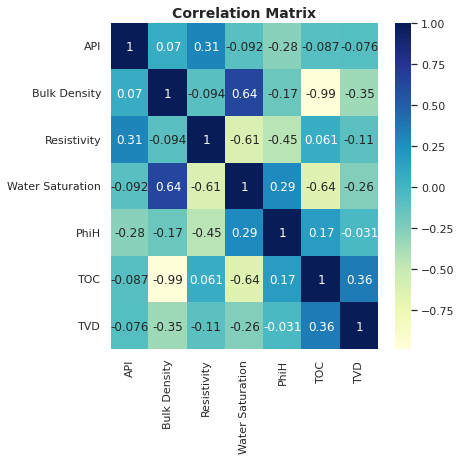

In [ ]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True,annot_kws={"size": 12}, cmap="YlGnBu", ax=ax)
ax.set_title('Correlation Matrix')

Quantitatively, the matrix below also confirms the very weak crorrelations.
A correlation of 64% cannot be considered any better than random, see N.N.Taleb.

On the other hand, TOC and Bulk Density are negatively correlated.

In [ ]:
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,API,Bulk Density,Resistivity,Water Saturation,PhiH,TOC,TVD
API,1.00,0.07,0.31,-0.09,-0.28,-0.09,-0.08
Bulk Density,0.07,1.00,-0.09,0.64,-0.17,-0.99,-0.35
Resistivity,0.31,-0.09,1.00,-0.61,-0.45,0.06,-0.11
Water Saturation,-0.09,0.64,-0.61,1.00,0.29,-0.64,-0.26
PhiH,-0.28,-0.17,-0.45,0.29,1.00,0.17,-0.03
TOC,-0.09,-0.99,0.06,-0.64,0.17,1.00,0.36
TVD,-0.08,-0.35,-0.11,-0.26,-0.03,0.36,1.00


# **PCA**

The original dataset contains 7 dimensions, and they´re mostly uncorrelated.
Therefore, it´ll be hard to reduce the dimensionality to either 2 or 3 (for the purpose of data visualization) while retaining 90% of total variance. We´ll have to settle for lower preserved variance.

In [ ]:
# scaled dataset
X_raw=df.values
scaler=StandardScaler()
scaler.fit(X_raw)
X_std=scaler.transform(X_raw)

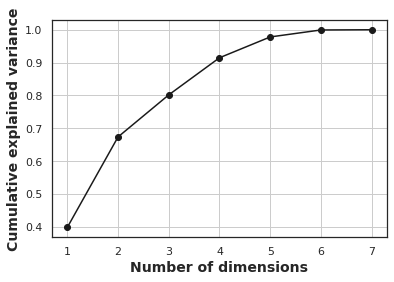

In [ ]:
# invoke PCA 
pca = PCA()
pca.fit(X_std)
pca.transform(X_std)

# explained variance
exp_var_pca=np.sum(pca.explained_variance_ratio_)
plt.plot(np.arange(1,X_raw.shape[1]+1),np.cumsum(pca.explained_variance_ratio_),'ko-')
plt.xlabel('Number of dimensions')
plt.ylabel('Cumulative explained variance')
plt.grid()

PCA with 2-dimensions

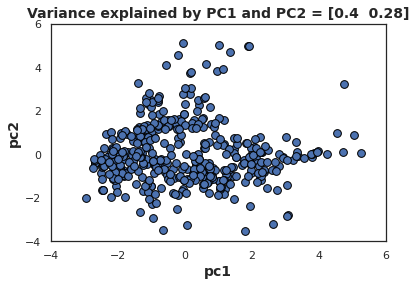

In [ ]:
# invoke pca with 2 dimensions
pca=PCA(n_components=2)
Z=pca.fit(X_std)
Z=pca.transform(X_std)

# include PCs in dataframe
df.loc[:,'PC1']=Z[:,0]
df.loc[:,'PC2']=Z[:,1]

# plot figs
fig = plt.figure()
ax = fig.add_subplot(111)
sc=ax.scatter(df['PC1'], df['PC2'],s=60,edgecolors=(0,0,0))
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_xlim(-4,6)
ax.set_ylim(-4,6)
plt.title(f"Variance explained by PC1 and PC2 = {np.round(pca.explained_variance_ratio_,2)}");
plt.savefig("pca.png",dpi=300)

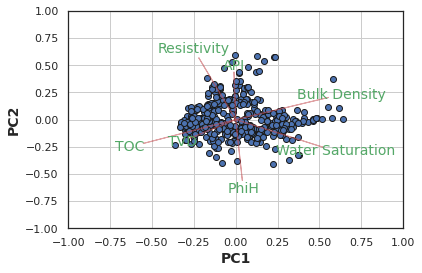

In [ ]:
# factor loadings
cols=['API',
        'Bulk Density',
        'Resistivity',
        'Water Saturation',
        'PhiH',
        'TOC',
        'TVD']
pca_factor_loadings(Z[:,0:2],np.transpose(pca.components_[0:2, :]),labels=cols)

# **K-means on 2-D PCA**

Let´s cluster the 2-dimensional PCA dataset.

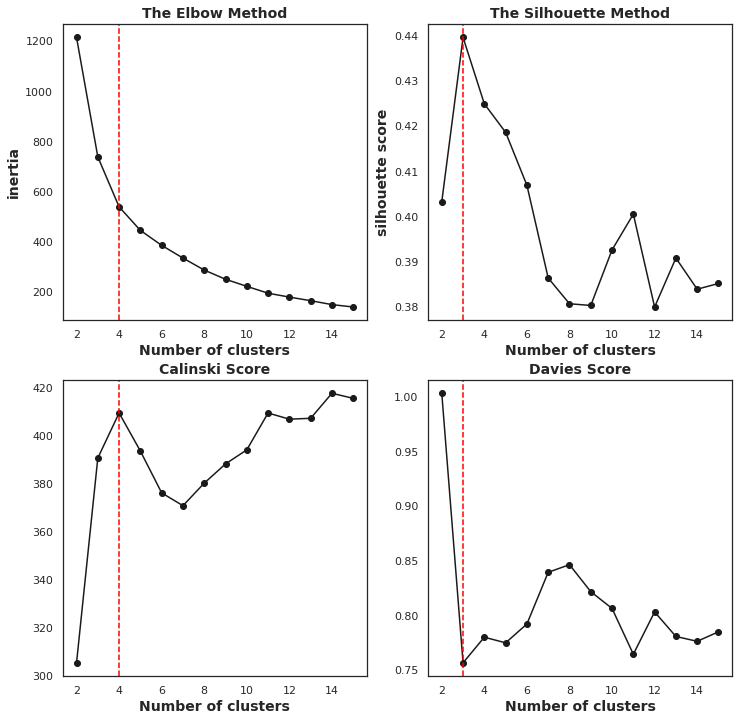

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score
# list for inertia score
inertia = []
# list for silhouette score
silh=[]
#list for calisnki score
cali=[]
#list for davis score
davis=[]
# select PC1 and PC2
cols_pc=['PC1','PC2']
X=df[cols_pc]
for i in range(2, 16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    # data for the elbow method
    inertia.append(kmeans.inertia_)
    # data for the silhouette score method
    silh.append(silhouette_score(X, kmeans.labels_))
    # data for calinski score
    cali.append(calinski_harabasz_score(X,kmeans.labels_))
    # data dor davis score
    davis.append(davies_bouldin_score(X,kmeans.labels_))

# plot elbow method and
# silhouette score
fig=plt.figure(figsize=(12,12))
ax1=plt.subplot(221)
ax2=plt.subplot(222)
ax3=plt.subplot(223)
ax4=plt.subplot(224)

ax1.plot(range(2,16), inertia,'ko-')
ax1.set_title('The Elbow Method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('inertia')
ax1.axvline(4, ls="--", c="red")

ax2.plot(range(2,16), silh,'ko-')
ax2.set_title('The Silhouette Method')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('silhouette score')
ax2.axvline(3, ls="--", c="red")

ax3.plot(range(2,16), cali,'ko-')
ax3.set_title('Calinski Score')
ax3.set_xlabel('Number of clusters')
ax3.axvline(4, ls="--", c="red")

ax4.plot(range(2,16), davis,'ko-')
ax4.set_title('Davies Score')
ax4.set_xlabel('Number of clusters')
ax4.axvline(3, ls="--", c="red")


**The number of clusters should be either 3 (according to silhouette and davies) or 4 (according to elbow and calinski). Let´s try both.**

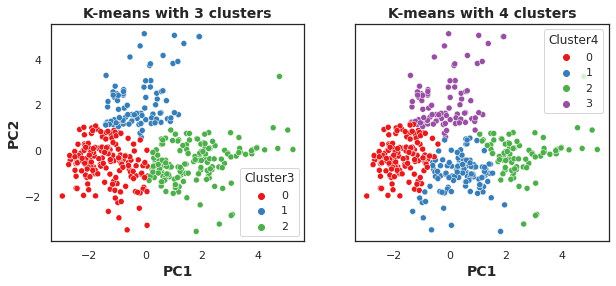

In [ ]:
# initialise and fit K-Means model
km3 = KMeans(n_clusters=3, init='k-means++').fit(X) 
km4 = KMeans(n_clusters=4, init='k-means++').fit(X)
# append labels to points
df.loc[:,'Cluster3'] = km3.labels_ 
df.loc[:,'Cluster4'] = km4.labels_
# plot clusters
fig1, (axes) = plt.subplots(1,2,figsize=(10,4), sharey=True)
axes[0].set_title("K-means with 3 clusters")
sns.scatterplot('PC1', 'PC2', data=df,
                hue='Cluster3', ax=axes[0], palette='Set1', legend='full')
axes[1].set_title("K-means with 4 clusters")
sns.scatterplot('PC1', 'PC2', data=df,
                hue='Cluster4', ax=axes[1], palette='Set1', legend='full')

We will choose 4 clusters.

In [ ]:
# check cluster size
kmeans4_clust_size = df.groupby('Cluster4').size().to_frame()
kmeans4_clust_size.columns = ["4 cluster size"]
kmeans4_clust_size

,4 cluster size
Cluster4,
0,147
1,122
2,85
3,84


Nows let´s see if we use TSNE instead.

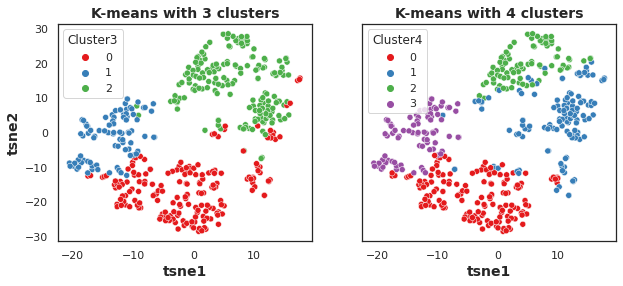

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
Ztsne=tsne.fit_transform(X_std)

df['tsne1']=Ztsne[:,0]
df['tsne2']=Ztsne[:,1]

# plot clusters
fig1, (axes) = plt.subplots(1,2,figsize=(10,4), sharey=True)
axes[0].set_title("K-means with 3 clusters")
sns.scatterplot('tsne1', 'tsne2', data=df,
                hue='Cluster3', ax=axes[0], palette='Set1', legend='full')
axes[1].set_title("K-means with 4 clusters")
sns.scatterplot('tsne1', 'tsne2', data=df,
                hue='Cluster4', ax=axes[1], palette='Set1', legend='full')


It also looks like k-means with 4 clusters look better, even though there´s some overlapping.

It must be noted this dataset contains some amount of noisy samples. They don't really cluster together well with the cluster they were assigned to. Maybe DBSCAN will show better results, as it´s capable of handling outliers.

Now let´s try PCA with 3-dimensions

Text(0.5, 0, 'pc3')

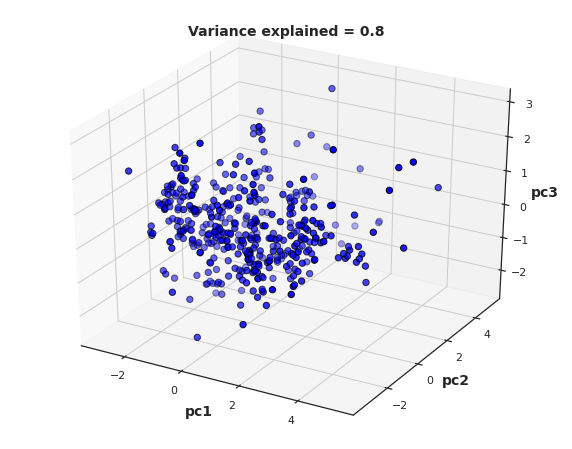

In [ ]:
# invoke pca with 3 dimensions
pca=PCA(n_components=3)
Z=pca.fit(X_std)
Z=pca.transform(X_std)
df.loc[:,'PC1']=Z[:,0]
df.loc[:,'PC2']=Z[:,1]
df.loc[:,'PC3']=Z[:,2]

# set up array for
# 3d plot
data=[Z[:,0],Z[:,1],Z[:,2]]
data=np.array(data)
data=np.transpose(data)
x, y, z = zip(*data)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,color='blue', s=40,edgecolors=(0,0,0))
ax.set_title(f"Variance explained = {np.round(np.sum(pca.explained_variance_ratio_),2)}");
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')

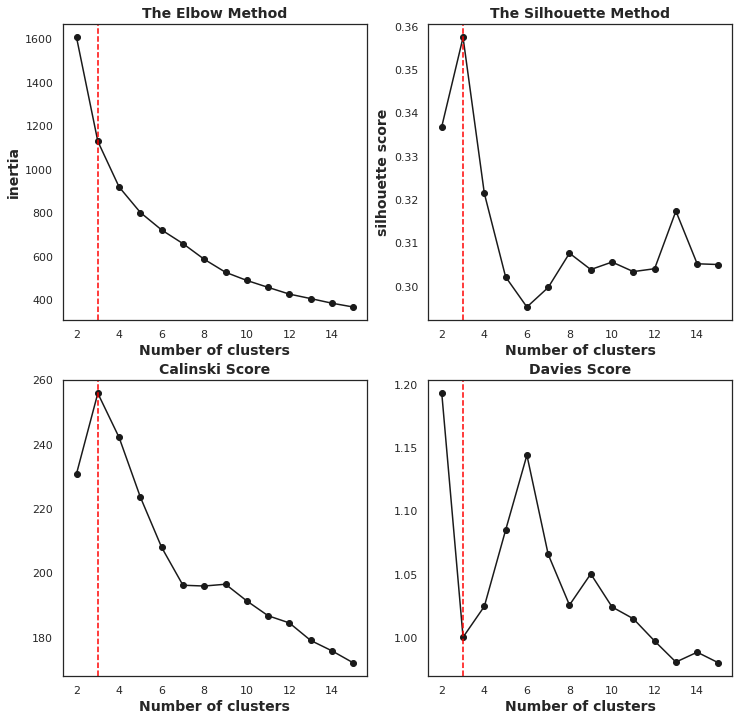

In [ ]:
inertia = []
silh=[]
cali=[]
davis=[]
cols_pc=['PC1','PC2','PC3']
X=df[cols_pc]

for i in range(2, 16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    # data for the elbow method
    inertia.append(kmeans.inertia_)
    # data for the silhouette score method
    silh.append(silhouette_score(X, kmeans.labels_))
    # data for calinski score
    cali.append(calinski_harabasz_score(X,kmeans.labels_))
    # data dor davis score
    davis.append(davies_bouldin_score(X,kmeans.labels_))

# plot elbow method and
# silhouette score
fig=plt.figure(figsize=(12,12))
ax1=plt.subplot(221)
ax2=plt.subplot(222)
ax3=plt.subplot(223)
ax4=plt.subplot(224)

ax1.plot(range(2,16), inertia,'ko-')
ax1.set_title('The Elbow Method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('inertia')
ax1.axvline(3, ls="--", c="red")

ax2.plot(range(2,16), silh,'ko-')
ax2.set_title('The Silhouette Method')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('silhouette score')
ax2.axvline(3, ls="--", c="red")

ax3.plot(range(2,16), cali,'ko-')
ax3.set_title('Calinski Score')
ax3.set_xlabel('Number of clusters')
ax3.axvline(3, ls="--", c="red")

ax4.plot(range(2,16), davis,'ko-')
ax4.set_title('Davies Score')
ax4.set_xlabel('Number of clusters')
ax4.axvline(3, ls="--", c="red")


With 3-dimensions, most metrics suggest 3 clusters instead of 4. Let´s try both!

First, let´s try with 3 clusters.

In [ ]:
# initialise and fit K-Means model with 3 clusters
km = KMeans(n_clusters=3, init='k-means++').fit(X) 
# append labels to points
df.loc[:,'Cluster'] = km.labels_ 

import plotly.express as px
cols=['PC1','PC2','PC3','Cluster']
df_3d=df[cols]
fig = px.scatter_3d(df_3d, x='PC1', y='PC2', z='PC3', color='Cluster',color_continuous_scale='Jet')
fig.show()

In [ ]:
# initialise and fit K-Means model with 4 clusters
km = KMeans(n_clusters=4, init='k-means++').fit(X) 
# append labels to points
df.loc[:,'Cluster'] = km.labels_ 

import plotly.express as px
cols=['PC1','PC2','PC3','Cluster']
df_3d=df[cols]
fig = px.scatter_3d(df_3d, x='PC1', y='PC2', z='PC3', color='Cluster',color_continuous_scale='Jet')
fig.show()

# **DBSCAN**

Let´s perform PCA to create a 2D-dataset.

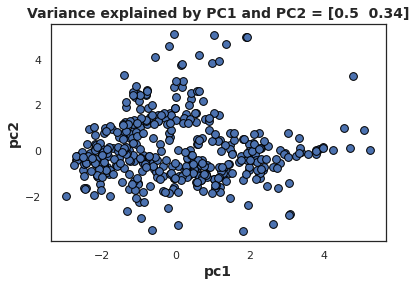

In [ ]:
# invoke pca with 2 dimensions
pca=PCA(n_components=2)
Z=pca.fit(X_std)
Z=pca.transform(X_std)

# include PCs in dataframe
df.loc[:,'PC1']=Z[:,0]
df.loc[:,'PC2']=Z[:,1]


#plot figs
fig = plt.figure()
ax = fig.add_subplot(111)
sc=ax.scatter(Z[:,0], Z[:,1],s=60,edgecolors=(0,0,0))
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
plt.title(f"Variance explained by PC1 and PC2 = {np.round(pca.explained_variance_ratio_,2)}");


cols_pc=['PC1','PC2']
X=df[cols_pc]

This snippet is here so we can play around with "eps" and "min_samples" and get a feel for what a good range could be.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
# perform DBSCAN
db=DBSCAN(eps=0.7,min_samples=3,metric='euclidean')
model=db.fit(X)
label=model.labels_
#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)
sample_cores[db.core_sample_indices_]=True
#Calculating the number of clusters
n_clusters=len(set(label))- (1 if -1 in label else 0)
print('No of clusters:',n_clusters)

No of clusters: 4


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from itertools import product

# create a grid of "eps" and
# "min_samples" to iterate over
eps_values = np.arange(0.3,0.4,0.01) # eps values to be investigated
min_samples = np.arange(10,20) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

# create a matrix featuring
# number of clusters and
# silhouette score for each
# combination of "eps" and "min_samples"
n_clusters = []
silh_score = []
for k in DBSCAN_params:
    db = DBSCAN(eps=k[0], min_samples=k[1]).fit(X)
    n_clusters.append(len(np.unique(db.labels_)))
    silh_score.append(silhouette_score(X, db.labels_))

Matrix of # of clusters

Text(0.5, 1.0, 'Number of clusters including outliers')

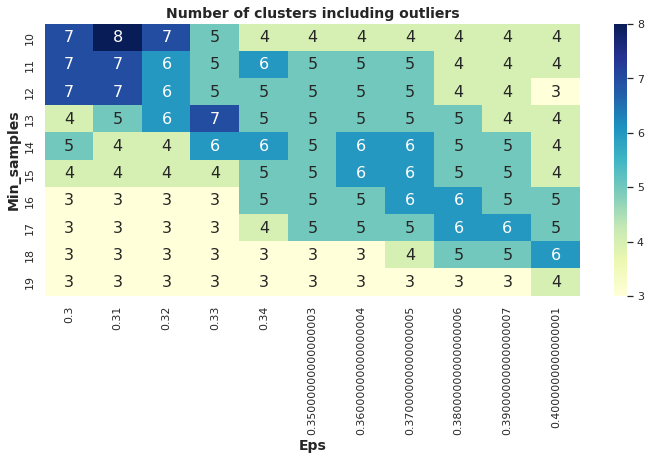

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = n_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters including outliers')

Matrix of Silhouette Score

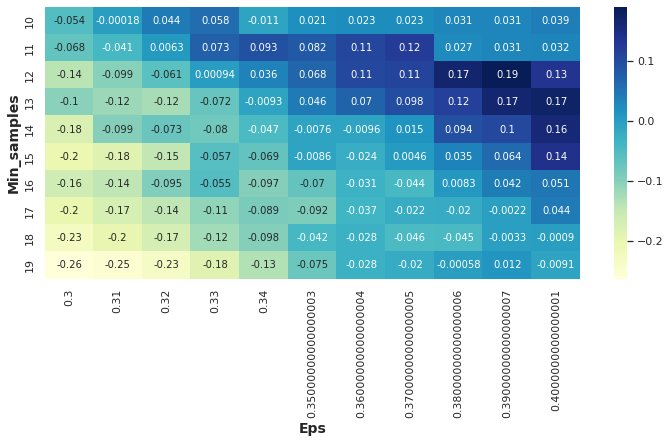

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = silh_score
pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

We can limit our search by looking at the silhouette matrix above. Our search range will be:


*   min_samples=[12,13,14]
*   eps=[0.38,0.39,0.40]



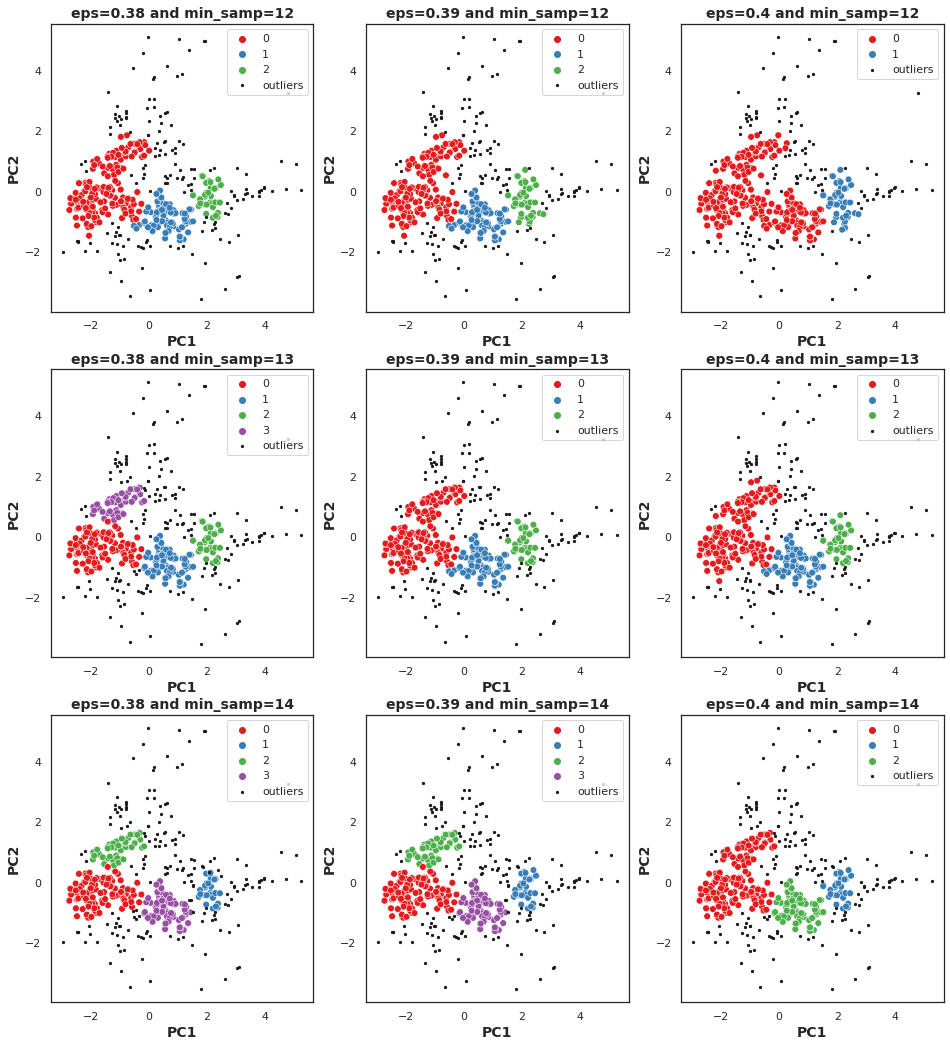

In [ ]:
min_samples=[12,13,14]
eps=[0.38,0.39,0.40]
subplots=[331,332,333,334,335,336,337,338,339]
plt.figure(figsize=(16,18))
i=0
for each_min_samp in min_samples:
  for each_eps in eps:
    DBS_clustering = DBSCAN(eps=each_eps, min_samples=each_min_samp).fit(X)
    DBSCAN_clustered = X.copy()
    DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points
    outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]
    
    plt.subplot(subplots[i])
    sns.scatterplot('PC1', 'PC2',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', legend='full', s=45)
    plt.scatter(outliers['PC1'], outliers['PC2'], s=5, label='outliers', c="k")
    plt.title(f"eps={each_eps} and min_samp={each_min_samp}")
    plt.legend()
    i=i+1

There seems to be 4 clusters, in line with K-means.

In [ ]:
eps=0.38
min_samp=13
DBS_clustering = DBSCAN(eps=eps, min_samples=min_samp).fit(X)
DBSCAN_clustered = X.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

Let´s plot again the 4 clusters identified by those hyperparameters and compare them with the K-means algorithm.

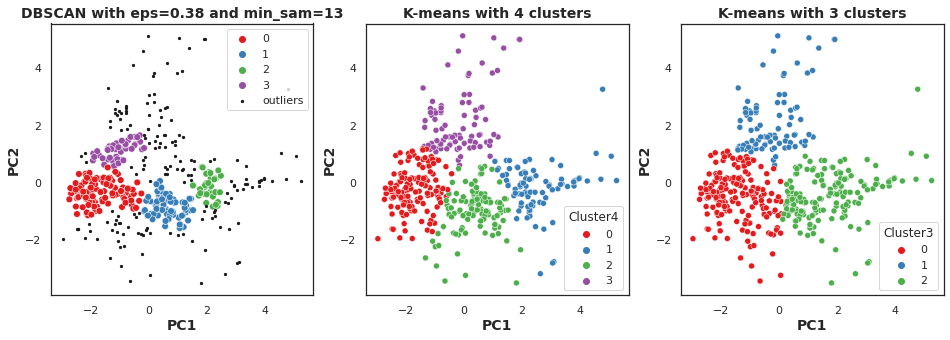

In [ ]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]
fig2, (axes) = plt.subplots(1,3,figsize=(16,5))
sns.scatterplot('PC1', 'PC2',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)
axes[0].scatter(outliers['PC1'], outliers['PC2'], s=5, label='outliers', c="k")
axes[0].set_title(f"DBSCAN with eps={eps} and min_sam={min_samp}")
axes[0].legend()

# initialise and fit K-Means model
km4 = KMeans(n_clusters=4, init='k-means++').fit(X)
# append labels to points
df.loc[:,'Cluster4'] = km4.labels_
# plot clusters
axes[1].set_title("K-means with 4 clusters")
scat_1 = sns.scatterplot('PC1', 'PC2', data=df,
                hue='Cluster4', ax=axes[1], palette='Set1', legend='full')

# initialise and fit K-Means model
km3 = KMeans(n_clusters=3, init='k-means++').fit(X)
# append labels to points
df.loc[:,'Cluster3'] = km3.labels_
# plot clusters
axes[2].set_title("K-means with 3 clusters")
scat_1 = sns.scatterplot('PC1', 'PC2', data=df,
                hue='Cluster3', ax=axes[2], palette='Set1', legend='full')

K-means vs DBSCAN (extracted from https://www.geeksforgeeks.org/difference-between-k-means-and-dbscan-clustering/)


*   [K] Clusters formed are more or less spherical or convex in shape and must have same feature size.
*   [D] Clusters formed are arbitrary in shape and may not have same feature size.
---
*   [K] K-means clustering is sensitive to the number of clusters specified.
*   [D] Number of clusters need not be specified.
---
*   [K] K-means Clustering is more efficient for large datasets.
*   [D] DBSCan Clustering can not efficiently handle high dimensional datasets.
---
*   [K] K-means Clustering does not work well with outliers and noisy datasets.
*   [D] DBScan clustering efficiently handles outliers and noisy datasets.
---
*   [K] 	In the domain of anomaly detection, this algorithm causes problems as anomalous points will be assigned to the same cluster as “normal” data points.
*   [D]  DBScan algorithm, on the other hand, locates regions of high density that are separated from one another by regions of low density.
---
*   [K] It requires one parameter : Number of clusters (K).
*   [D] It requires two parameters : Radius(R) and Minimum Points(M).
R determines a chosen radius such that if it includes enough points within it, it is a dense area. M determines the minimum number of data points required in a neighborhood to be defined as a cluster.
---
*   [K] Varying densities of the data points doesn’t affect K-means clustering algorithm.
*   [D] DBScan clustering does not work very well for sparse datasets or for data points with varying density.

